**Modello di classificazione classico, senza cose strane**

#### Metodo dei gradienti ortogonali

Struttura con 4 o piu layer


- fase 1: solito training su L1
- fase 2: training su L2, ma step dopo step il gradiente di L2 viene proiettato sull'ortogonale al gradiente di L1, che in questo modo dovrebbe rimanere circa invariata 

In [1]:
def l2_normalize(tensor):
    norm = tensor.norm(p=2)
    normalized_tensor = tensor / norm
    return normalized_tensor

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import torch.linalg as linalg

dataset = torch.tensor([[0.,8.],[1.,8.],[2.,8.],[3.,8.],[4.,8.],
                        [0.,7.],[1.,7.],[2.,7.],[3.,7.],[4.,7.],
                        [0.,6.],[1.,6.],[2.,6.],[3.,6.],[4.,6.],
                        [0.,5.],[1.,5.],[2.,5.],[3.,5.],[4.,5.],
                        [0.,4.],[1.,4.],[2.,4.],[3.,4.],[4.,4.],
                        [0.,3.],[1.,3.],[2.,3.],[3.,3.],[4.,3.],
                        [0.,2.],[1.,2.],[2.,2.],[3.,2.],[4.,2.],
                        [0.,1.],[1.,1.],[2.,1.],[3.,1.],[4.,1.]])

labels = torch.tensor(  [0.,0.,0.,0.,0.,
                         0.,0.,0.,1.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,1.,0.,0.,
                         1.,1.,1.,0.,1.,
                         1.,1.,0.,1.,1.,
                         1.,0.,1.,1.,1.,
                         1.,1.,1.,1.,1.])
labels = torch.tensor(  [-1.,-1.,-1.,-1.,-1.,
                         -1.,-1.,-1.,-1.,-1.,
                         -1.,-1.,-1.,-1.,-1.,
                         -1.,-1.,1.,-1.,-1.,
                         1.,1.,1.,-1.,1.,
                         1.,1.,-1.,1.,1.,
                         1.,1.,1.,1.,1.,
                         1.,1.,1.,1.,1.])

train_data = []
train_data0 = []
train_data1 = []

for i in range(len(dataset)):
   train_data.append([dataset[i], labels[i]])
   if labels[i] == -1:
      train_data0.append([dataset[i], labels[i]])
   elif labels[i] == 1:
      train_data1.append([dataset[i], labels[i]])

In [3]:
class HingeLoss(nn.Module):
    def __init__(self,margin=1):
        super(HingeLoss, self).__init__()
        self.margin = margin
    def forward(self, inputs, targets):
        #loss = -1 * (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        loss = torch.max(torch.tensor(0.),self.margin - inputs * targets)
        return loss.mean()

In [4]:
class ModelloF(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size):
        super(ModelloF, self).__init__()
        self.ort_base = None
        
        self.loss = HingeLoss(1)

        self.W0 = torch.nn.Linear(input_size, hidden_size)
        self.W1 = torch.nn.Linear(hidden_size, hidden_size)
        self.W1_1 = torch.nn.Linear(hidden_size,hidden_size)
        self.W1_2 = torch.nn.Linear(hidden_size,hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)
        

        self.ReLU = torch.nn.ReLU()

        self.Sigmoid = torch.nn.Sigmoid()

        self.optimizer = torch.optim.SGD(self.parameters(),lr = 0.002)
        
    def forwardL1(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2(W1 * R1(W0 * x))) 
        '''
        
        z = self.ReLU(self.W0(x))
        u = self.W1(z)
        v = self.ReLU(self.W1_2(self.ReLU(self.W1_1(self.ReLU(u)))))

        y = self.W2(v)

        return y, v.clone().detach() # Ritorno sa y che le v (che mi servono per la proiezione)

    def forwardL2(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2( u))
        '''

        z = self.ReLU(self.W0(x))
        u = self.W1(z)
        v = self.ReLU(self.W1_2(self.ReLU(self.W1_1(self.ReLU(u)))))

        y = self.W2(v)

        return y
        
    


# ----------------------------------------------------------

    def forward(self, x, mode = 'inference'):
        if mode == 'inference':
            with torch.no_grad():
                y, _ = self.forwardL1(x)
            return self.Sigmoid(y)
        elif mode == 'L1':
            return self.forwardL1(x)
        elif mode == 'L2':
            return self.forwardL2(x)


    def train(self, dl, mode = 'L1',dl_ort = None):
        
        for x,y in dl:
            self.optimizer.zero_grad()

            if mode == 'L1':
                y_pred, _ = self(x, mode)
                e = self.loss(y_pred, y.unsqueeze(1))
                e.backward()
                self.optimizer.step()
                
            elif mode == 'L2':
                y_pred = self(x, mode)
                e = self.loss(y_pred, y.unsqueeze(1))
                e.backward()
                
                grad_L2 = torch.cat([p.grad.flatten() for p in self.parameters()]) #prende prima i weights poi i bias, partendo dall'inizio del modello
                              
                self.optimizer.zero_grad()
                
                
                for a,b in dl_ort:  #passo tutte le unità di dl1 e mi facio la backward, tengo il gradiente. faccio la media dei gradienti cosi ho il vero gradiente su tutto il dataset dl1
                    a_pred, _ = self(a,'L1')
                    
                    e_L1 = self.loss(a_pred,b.unsqueeze(1))
                    e_L1.backward()
                    grad_L1 = torch.cat([p.grad.flatten() for p in self.parameters()])
                    #self.optimizer.zero_grad()
                                
                
                grad_L2_orto = grad_L2 - (l2_normalize(grad_L1)* (l2_normalize(grad_L1).matmul(grad_L2)))
                
                prev_len = 0 #punto di partenza per prendere i gradienti dal vettore
                
                
                for param in self.parameters():
                    
                    #print(param.grad.flatten().reshape(40,2)) #risolvere in qualche modo questo robo
                    #print('size param '+ str(param.grad.size()))
                    if param.grad.dim()== 1:
                        #print('size non conforme')
                        dim1 = 1
                        dim0 = param.grad.size()[0]
                    else:
                        #print('size conforme')
                        dim0= param.grad.size()[0]
                        dim1= param.grad.size()[1] 
                    
                    #print('dimensions '+str(dim0)+' '+str(dim1))
                    
                    nuovi_parametri = grad_L2_orto[prev_len:(dim0*dim1+prev_len)].reshape(dim0,dim1)
                    #print('dim nuovi parametri'+ str(nuovi_parametri.size()))
                    
                    if param.grad.dim()==1 and param.grad.size() != torch.Size([1]):
                        #print(nuovi_parametri.squeeze().size())
                        param.grad = nuovi_parametri.squeeze()
                    elif param.grad.dim()==1 and param.grad.size() == torch.Size([1]):
                        #print('caso particolare')
                        param.grad = nuovi_parametri.squeeze(dim=1)                            
                    else:
                        param.grad = nuovi_parametri
                    prev_len = dim0*dim1 + prev_len 
                    #print('prev_len alla fine'+ str(prev_len)+'\n')
                        
                        
                    
                #print('QUI')
                self.optimizer.step()
                  
            
        return e.detach().numpy()

# ----------------------------------------------------------

    def _Projection(self, u):
        # Project u on them and return it
        return torch.mm(u, self.ort_base)

    
    def generate_orthogonal_base(self, dl):
        base = None
        with torch.no_grad():
            for x,y in dl:  
                _, v = self(x, 'L1')
                if base is None:
                    base = v
                else:
                    base = torch.cat((base, v.clone().detach()), dim = 0)
        
        q, r = torch.linalg.qr(base.T, mode = 'reduced')
        diag = torch.diagonal(r)
        mask = torch.where(diag != 0)
        base = q.T[mask] # Base indipendenti, normalizzate
        # BASE Nx10
        #print(base)
        #print(base.size())
        self.ort_base = self._orthogonal_base(base)

    def _orthogonal_base(self, A):
            # A = Nx10
            A = A.T
            # A = 10xN
                
            AAT = torch.matmul(A.T, A)
            # AAT = NxN

            AAT_INV = torch.linalg.solve(AAT, torch.eye(AAT.shape[0])) 
            # AAT_INV = NxN

            P_a = torch.matmul(A, AAT_INV) 
            # P_a = 10xN
            P_a = torch.matmul(P_a, A.T) 
            # P_a = 10x10
            P = torch.eye(P_a.shape[0]) - P_a 
            #print('p')
            #print(P)
            #print(P.size())
            return P

In [5]:
#torch.manual_seed(66) #viene perfetto da subito
torch.manual_seed(74)
modello = ModelloF(2,1,500)

dl0 = torch.utils.data.DataLoader(train_data0, batch_size = 8, shuffle = True)
dl1 = torch.utils.data.DataLoader(train_data1, batch_size = 8, shuffle = True)
dl1_for_ort = torch.utils.data.DataLoader(train_data1,batch_size = 19, shuffle = False)
dl_tot = torch.utils.data.DataLoader(train_data,batch_size = 8, shuffle = True)

/home/matteo/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


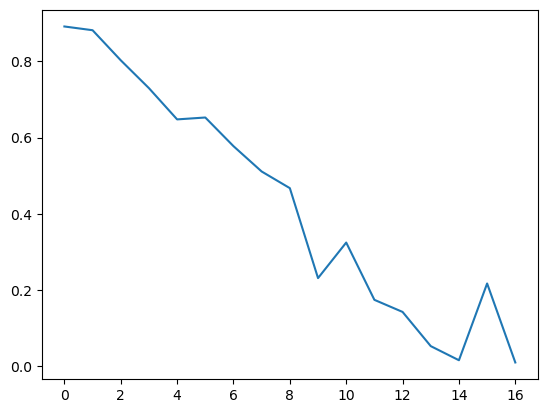

In [6]:
#TRAIN FASE 1
e = 1
err = []
while e > 1e-2:
    e = modello.train(dl1, 'L1') # Dentro dl ci deveno essere solo y == 1, ed usiamo BCEWithLogitsLoss
    err.append(e) 

plt.plot([x for x in range(len(err))], err, label = "Loss")
plt.show()

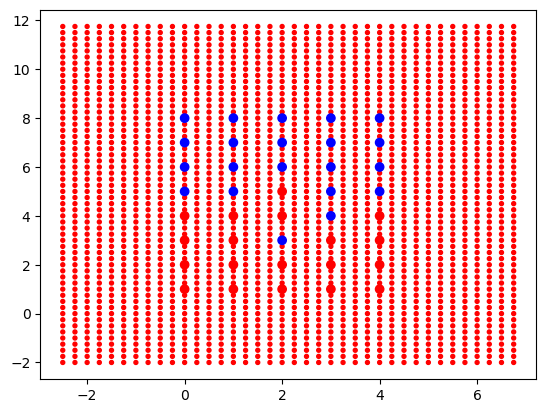

In [7]:
#PLOT FASE 1

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] < -0.5 else 'red' if p[2][0] > 0.5 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione

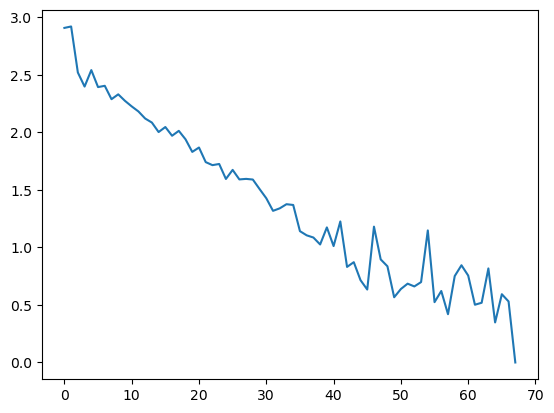

In [8]:
#TRAIN FASE 2

err0 = []

e0 = 1
#modello.generate_orthogonal_base(dl1)
i = 1
while e0 > 1e-3:
    i = i +1
    e0 = modello.train(dl0, 'L2', dl1_for_ort)
    err0.append(e0)
    
    

plt.plot([x for x in range(len(err0))], err0)


plt.show()

In [9]:
modello(torch.tensor([0.,0.]),'L1') # non si capisce perchè stampi sta roba

(tensor([1.4119], grad_fn=<ViewBackward0>),
 tensor([0.0000, 0.0000, 0.0000, 0.0926, 0.0152, 0.0018, 0.0000, 0.0155, 0.0018,
         0.0444, 0.0000, 0.2394, 0.0000, 0.1055, 0.0876, 0.2001, 0.0000, 0.0025,
         0.0000, 0.1617, 0.0739, 0.0000, 0.0814, 0.2333, 0.0000, 0.0000, 0.0200,
         0.0000, 0.0000, 0.0000, 0.0693, 0.0908, 0.2809, 0.0084, 0.0176, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0939, 0.0000, 0.0024, 0.0085, 0.0000, 0.0000,
         0.0318, 0.0000, 0.0263, 0.0253, 0.0000, 0.0000, 0.1215, 0.0000, 0.0356,
         0.0000, 0.2327, 0.0144, 0.0000, 0.0000, 0.0506, 0.0000, 0.0000, 0.0000,
         0.0850, 0.0000, 0.0317, 0.0000, 0.0460, 0.0000, 0.0000, 0.1663, 0.0077,
         0.0640, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0160, 0.0822,
         0.0000, 0.0000, 0.0000, 0.0007, 0.0496, 0.0000, 0.0000, 0.0534, 0.0000,
         0.0101, 0.1434, 0.0830, 0.0000, 0.0000, 0.0000, 0.0884, 0.0000, 0.0000,
         0.1282, 0.0000, 0.0000, 0.0000, 0.0152, 0.0025, 0.0000, 

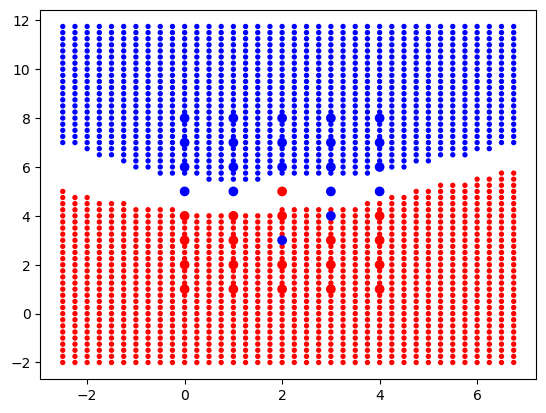

In [10]:
#PLOT FASE 2

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] < 0.4 else 'red' if p[2][0] > 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione